In [18]:
import numpy as np 
import pandas as pd

In [19]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [20]:
train_data = datasets.ImageFolder('images', transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

In [21]:
import torch.nn.functional as F

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.utils import save_image
import os

batch_size = 32

imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [23]:
import torchvision.utils as vutils

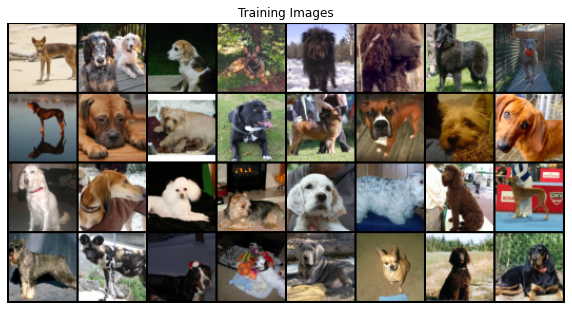

In [24]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images");
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [25]:
class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False),
                                  nn.BatchNorm2d(nfeats * 2),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False),
                                  nn.BatchNorm2d(nfeats * 4),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False),
                                  nn.BatchNorm2d(nfeats * 8),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(nfeats * 8, 1, 4, 1, 0, bias=False),
                                  nn.Sigmoid()
                                  )
    def forward(self, x):
        return self.model(x).view(-1, 1)

In [26]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nfeats * 8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfeats * 8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfeats * 4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfeats * 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfeats),
            nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False),
            nn.Tanh()
        )
        

    def forward(self, x): 
        return self.model(x)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0003
beta1 = 0.5

netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 1.0
fake_label = 0
batch_size = train_loader.batch_size


In [34]:
epochs = 30

step = 0
for epoch in range(epochs):
    for ii, (real_images, train_labels) in enumerate(train_loader):
        # train discriminator with real images
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        #print(type(output[0]))
        #print(criterion(output, labels))
        errD_real = criterion(output, labels)
        #print(type(errD_real))
        errD_real.backward()
        D_x = output.mean().item() # want to make sure that discriminator correctly classifies these samples as real, minimize error

        # train Discriminator with fake data
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # training the generator
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels) # want outputs to be as close to 1, trick discriminator into thinking fake is real
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if step % 500 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        
        
# torch.save(netG.state_dict(), 'generator.pth')
# torch.save(netD.state_dict(), 'discriminator.pth')

[1/1][0/644] Loss_D: 0.7146 Loss_G: 6.0063 D(x): 0.5131 D(G(z)): 0.0078 / 0.0027


KeyboardInterrupt: 

In [ ]:
if not os.path.exists('output_images'):
    os.mkdir('output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('output_images', f'image_{i_batch+i_image:05d}.png'))


#import shutil
#shutil.make_archive('images', 'zip', 'output_images')

In [ ]:
fig = plt.figure(figsize=(25, 16))
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [ ]:
print()